In [2]:
# --- Notebook Setup and Imports ---
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure basic logging for visibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Add project root to sys.path to enable absolute imports from 'src'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Add courselib parent path to sys.path
courselib_parent_path = os.path.abspath(os.path.join(project_root, "..", "AppliedML"))
if courselib_parent_path not in sys.path:
    sys.path.insert(0, courselib_parent_path)

# --- Configure Logging ---
if not logging.root.handlers:
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Import Project-Specific Modules ---
from src.data.data_processor import AirQualityProcessor
from src.features.feature_engineer import LagFeatureEngineer
from src.models.train_model import ModelEvaluator
from src.models.model_selection import evaluate_lag_depth_effect
from src.visualization.analysis import (
    plot_acf_pacf, 
    plot_error_by_time_group
)
from src.visualization.plotting import (
    plot_time_series,
    plot_residuals,
    plot_coefficients,
    plot_predictions_vs_actual,
    plot_error_by_time_group,
    plot_lag_depth_results
)
from src.utils.config import TARGET_POLLUTANT, START_DATE, END_DATE, LAG_DEPTH # LAG_DEPTH for initial setup example

# --- Import External Libraries for Models ---
from courselib.models.linear_models import LinearRegression
from courselib.optimizers import GDOptimizer
from sklearn.linear_model import Ridge # Example scikit-learn model

# For better display of DataFrames in Jupyter
from IPython.display import display

logger.info("All necessary modules and libraries imported.")

2025-07-15 21:31:04,840 - INFO - All necessary modules and libraries imported.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# --- Configuration ---

# --- Pipeline Parameters ---
# Data parameters
PIPELINE_TARGET_POLLUTANT = TARGET_POLLUTANT # From utils/config.py
PIPELINE_START_DATE = START_DATE           # From utils/config.py
PIPELINE_END_DATE = END_DATE               # From utils/config.py

# Lag depths for comprehensive evaluation
PIPELINE_TEST_LAGS = [1, 2, 3, 6, 12, 24, 48] # Example lags to test

# Model configurations for comprehensive evaluation
# These match what's expected by model_selection.py and train_model_class.py
PIPELINE_MODEL_CONFIGS = {
    "Courselib LR (GD 0.0001)": {
        "model_class": LinearRegression,
        "is_courselib_model": True,
        "optimizer": GDOptimizer(learning_rate=0.0001),
        "fit_params": {"num_epochs": 2000, "batch_size": 32}
    },
    "Courselib LR (GD 0.001)": {
        "model_class": LinearRegression,
        "is_courselib_model": True,
        "optimizer": GDOptimizer(learning_rate=0.001),
        "fit_params": {"num_epochs": 2000, "batch_size": 32}
    },
    "Scikit-learn Ridge (Alpha 1.0)": {
        "model_class": Ridge,
        "is_courselib_model": False,
        "init_params": {"alpha": 1.0}
    },
    "Scikit-learn Ridge (Alpha 0.1)": {
        "model_class": Ridge,
        "is_courselib_model": False,
        "init_params": {"alpha": 0.1}
    }
}

logger.info("Pipeline configuration loaded.")

2025-07-15 21:32:48,993 - INFO - Pipeline configuration loaded.


2025-07-15 21:33:08,572 - INFO - --- Data Loading and Initial Exploration ---
2025-07-15 21:33:09,086 - INFO - Raw data loaded and initially parsed.
2025-07-15 21:33:09,104 - INFO - Loaded time series data for NO2(GT) from 10/03/2004 to 08/06/2004. Shape: (1716,)



First 5 rows of the time series:


DateTime
2004-03-10 18:00:00    113.0
2004-03-10 19:00:00     92.0
2004-03-10 20:00:00    114.0
2004-03-10 21:00:00    122.0
2004-03-10 22:00:00    116.0
Name: NO2(GT), dtype: float64


Time series basic info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 1716 entries, 2004-03-10 18:00:00 to 2004-06-08 23:00:00
Series name: NO2(GT)
Non-Null Count  Dtype  
--------------  -----  
1716 non-null   float64
dtypes: float64(1)
memory usage: 26.8 KB

Time series descriptive statistics:


count    1716.000000
mean       95.695804
std        32.773516
min         8.000000
25%        73.000000
50%        96.000000
75%       119.000000
max       196.000000
Name: NO2(GT), dtype: float64

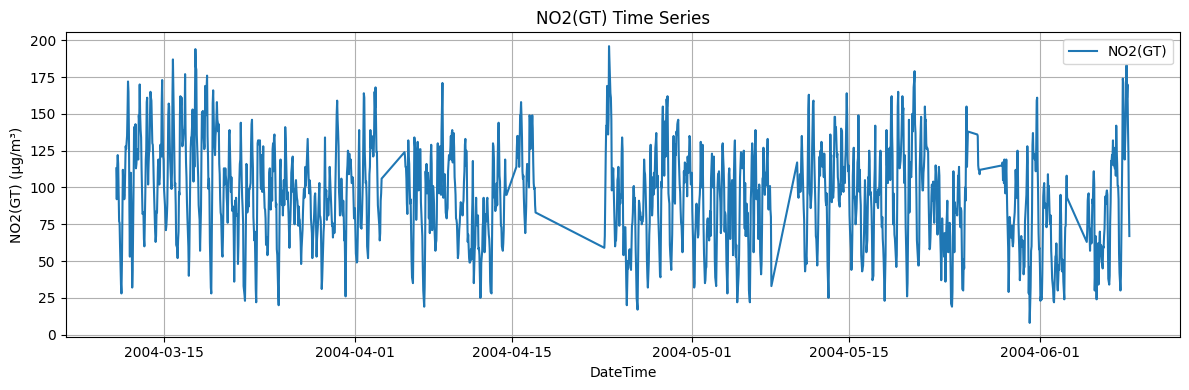

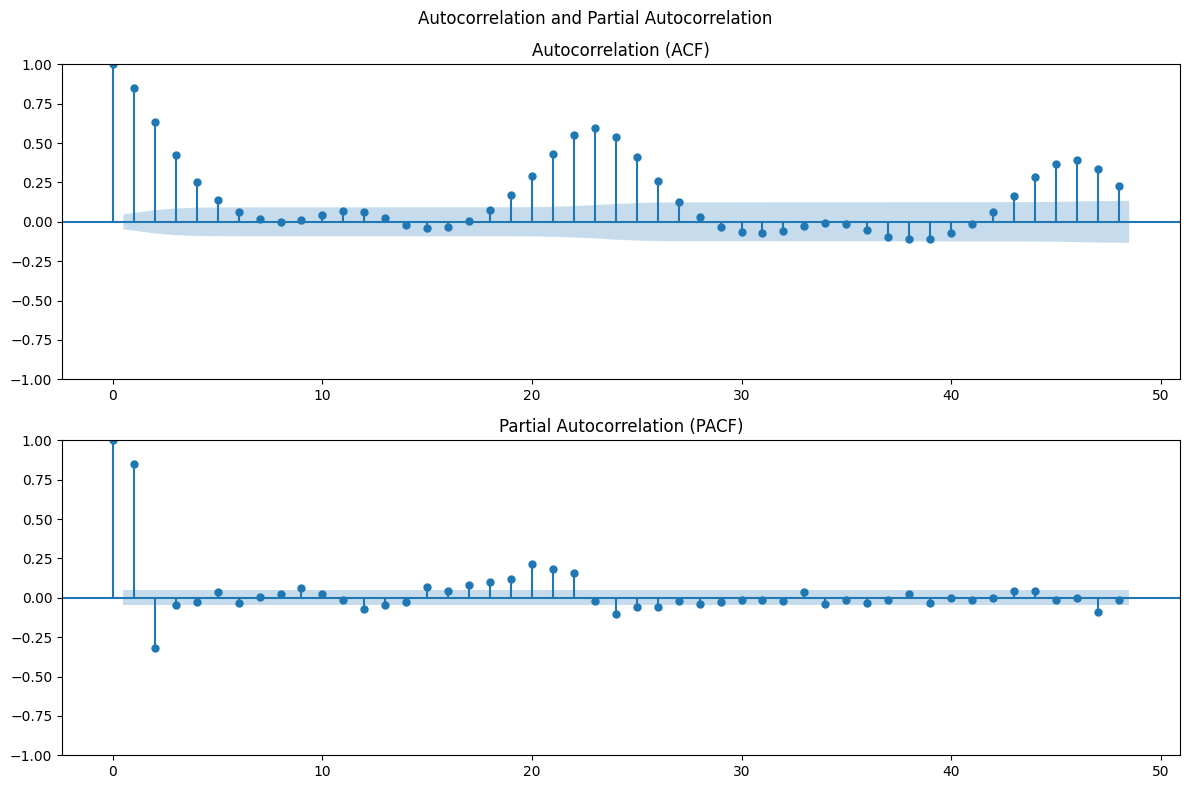

In [4]:
# --- Data Loading and Initial Exploration ---

logger.info("--- Data Loading and Initial Exploration ---")

try:
    processor = AirQualityProcessor(
        target_pollutant=PIPELINE_TARGET_POLLUTANT,
        start_date=PIPELINE_START_DATE,
        end_date=PIPELINE_END_DATE
    )
    time_series = processor.get_target_time_series()
    
    if time_series.empty:
        logger.error("Initial time series data is empty. Please check data source and dates.")
    else:
        logger.info(f"Loaded time series data for {PIPELINE_TARGET_POLLUTANT} "
                    f"from {PIPELINE_START_DATE} to {PIPELINE_END_DATE}. Shape: {time_series.shape}")
        
        print("\nFirst 5 rows of the time series:")
        display(time_series.head())
        print("\nTime series basic info:")
        time_series.info()
        print("\nTime series descriptive statistics:")
        display(time_series.describe())

        # Plot Initial Time Series
        plot_time_series(time_series, title=f"{PIPELINE_TARGET_POLLUTANT} Time Series", 
                         ylabel=f"{PIPELINE_TARGET_POLLUTANT} (µg/m³)")
        
        # Plot Initial ACF/PACF Analysis
        plot_acf_pacf(time_series, lags=48)

except Exception as e:
    logger.exception("An error occurred during data loading or initial visualization.")

2025-07-15 21:34:23,232 - INFO - --- Starting Comprehensive Lag Depth Analysis ---
2025-07-15 21:34:23,239 - INFO - Starting lag depth effect evaluation for depths: [1, 2, 3, 6, 12, 24, 48]
2025-07-15 21:34:23,395 - INFO - Raw data loaded and initially parsed.
2025-07-15 21:34:23,404 - INFO - Performing data split and scaling...
2025-07-15 21:34:23,410 - INFO - Training data shape: X=(1372, 1), y=(1372,)
2025-07-15 21:34:23,411 - INFO - Testing data shape: X=(343, 1), y=(343,)
2025-07-15 21:34:23,412 - INFO - Test Y index shape: 343
2025-07-15 21:34:23,414 - INFO - --- Starting evaluation for Courselib LR (GD 0.0001) ---


Generating 1 lag features and aligning target vector...


2025-07-15 21:34:36,168 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:34:36,172 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:34:36,175 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 149.9533, Train MAE: 13.5523, Train RMSE: 12.2455 | Test MSE: 149.6699, Test MAE: 13.3882, Test RMSE: 12.2340
2025-07-15 21:34:36,178 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:34:36,179 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 12.2455, Test RMSE: 12.2340).
2025-07-15 21:34:36,181 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:34:49,648 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:34:49,652 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:34:49,654 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 149.9531, Train MAE: 13.5525, Train RMSE: 12.2455 | Test MSE: 149.6999, Test MAE: 13.3894, Test RMSE: 12.2352
2025-07-15 21:

Generating 2 lag features and aligning target vector...


2025-07-15 21:35:00,786 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:35:00,791 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:35:00,792 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 138.9367, Train MAE: 12.9364, Train RMSE: 11.7871 | Test MSE: 142.6494, Test MAE: 13.2168, Test RMSE: 11.9436
2025-07-15 21:35:00,793 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:35:00,794 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 11.7871, Test RMSE: 11.9436).
2025-07-15 21:35:00,796 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:35:10,811 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:35:10,817 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:35:10,818 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 133.6654, Train MAE: 12.5707, Train RMSE: 11.5614 | Test MSE: 137.3726, Test MAE: 13.0093, Test RMSE: 11.7206
2025-07-15 21:

Generating 3 lag features and aligning target vector...


2025-07-15 21:35:21,112 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:35:21,119 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:35:21,121 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 137.1930, Train MAE: 12.8156, Train RMSE: 11.7129 | Test MSE: 147.7163, Test MAE: 13.5871, Test RMSE: 12.1539
2025-07-15 21:35:21,125 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:35:21,127 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 11.7129, Test RMSE: 12.1539).
2025-07-15 21:35:21,128 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:35:35,008 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:35:35,013 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:35:35,015 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 132.8135, Train MAE: 12.5303, Train RMSE: 11.5245 | Test MSE: 139.1176, Test MAE: 13.1530, Test RMSE: 11.7948
2025-07-15 21:

Generating 6 lag features and aligning target vector...


2025-07-15 21:35:46,964 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:35:46,968 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:35:46,969 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 137.2057, Train MAE: 12.8345, Train RMSE: 11.7135 | Test MSE: 148.3246, Test MAE: 13.6109, Test RMSE: 12.1789
2025-07-15 21:35:46,972 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:35:46,973 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 11.7135, Test RMSE: 12.1789).
2025-07-15 21:35:46,974 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:35:59,080 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:35:59,086 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:35:59,088 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 132.1107, Train MAE: 12.4961, Train RMSE: 11.4939 | Test MSE: 141.8323, Test MAE: 13.2788, Test RMSE: 11.9093
2025-07-15 21:

Generating 12 lag features and aligning target vector...


2025-07-15 21:36:10,663 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:36:10,667 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:36:10,669 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 135.3529, Train MAE: 12.7508, Train RMSE: 11.6341 | Test MSE: 148.4531, Test MAE: 13.6560, Test RMSE: 12.1841
2025-07-15 21:36:10,670 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:36:10,670 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 11.6341, Test RMSE: 12.1841).
2025-07-15 21:36:10,671 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:36:22,333 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:36:22,337 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:36:22,338 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 130.6165, Train MAE: 12.4532, Train RMSE: 11.4288 | Test MSE: 141.0072, Test MAE: 13.3092, Test RMSE: 11.8746
2025-07-15 21:

Generating 24 lag features and aligning target vector...


2025-07-15 21:36:36,946 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:36:36,951 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:36:36,952 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 110.5324, Train MAE: 11.4743, Train RMSE: 10.5134 | Test MSE: 148.7733, Test MAE: 13.6170, Test RMSE: 12.1973
2025-07-15 21:36:36,953 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:36:36,954 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 10.5134, Test RMSE: 12.1973).
2025-07-15 21:36:36,955 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:36:49,340 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:36:49,344 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:36:49,346 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 106.6513, Train MAE: 11.1832, Train RMSE: 10.3272 | Test MSE: 137.2741, Test MAE: 12.9943, Test RMSE: 11.7164
2025-07-15 21:

Generating 48 lag features and aligning target vector...


2025-07-15 21:37:03,459 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:37:03,464 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:37:03,465 - INFO - Model Courselib LR (GD 0.0001) - Train MSE: 104.7879, Train MAE: 11.1153, Train RMSE: 10.2366 | Test MSE: 152.6983, Test MAE: 13.6073, Test RMSE: 12.3571
2025-07-15 21:37:03,466 - INFO - --- Finished evaluation for Courselib LR (GD 0.0001) ---
2025-07-15 21:37:03,467 - INFO -     - Courselib LR (GD 0.0001) metrics recorded (Train RMSE: 10.2366, Test RMSE: 12.3571).
2025-07-15 21:37:03,469 - INFO - --- Starting evaluation for Courselib LR (GD 0.001) ---
2025-07-15 21:37:18,710 - INFO - Model LinearRegression trained successfully.
2025-07-15 21:37:18,715 - INFO - Predictions generated for LinearRegression.
2025-07-15 21:37:18,717 - INFO - Model Courselib LR (GD 0.001) - Train MSE: 100.0420, Train MAE: 10.7849, Train RMSE: 10.0021 | Test MSE: 140.0261, Test MAE: 12.9769, Test RMSE: 11.8333
2025-07-15 21:

,Lag Depth,Model,Metric Type,MSE,MAE,RMSE
0,1,Courselib LR (GD 0.0001),Train,149.953283,13.552299,12.245541
1,1,Courselib LR (GD 0.0001),Test,149.669923,13.388177,12.233966
2,1,Courselib LR (GD 0.001),Train,149.953109,13.552494,12.245534
3,1,Courselib LR (GD 0.001),Test,149.699933,13.389406,12.235192
4,1,Scikit-learn Ridge (Alpha 1.0),Train,149.953295,13.552272,12.245542
5,1,Scikit-learn Ridge (Alpha 1.0),Test,149.739881,13.391533,12.236825
6,1,Scikit-learn Ridge (Alpha 0.1),Train,149.953109,13.552499,12.245534
7,1,Scikit-learn Ridge (Alpha 0.1),Test,149.705676,13.389675,12.235427
8,2,Courselib LR (GD 0.0001),Train,138.936683,12.936407,11.787141
9,2,Courselib LR (GD 0.0001),Test,142.649415,13.216822,11.943593


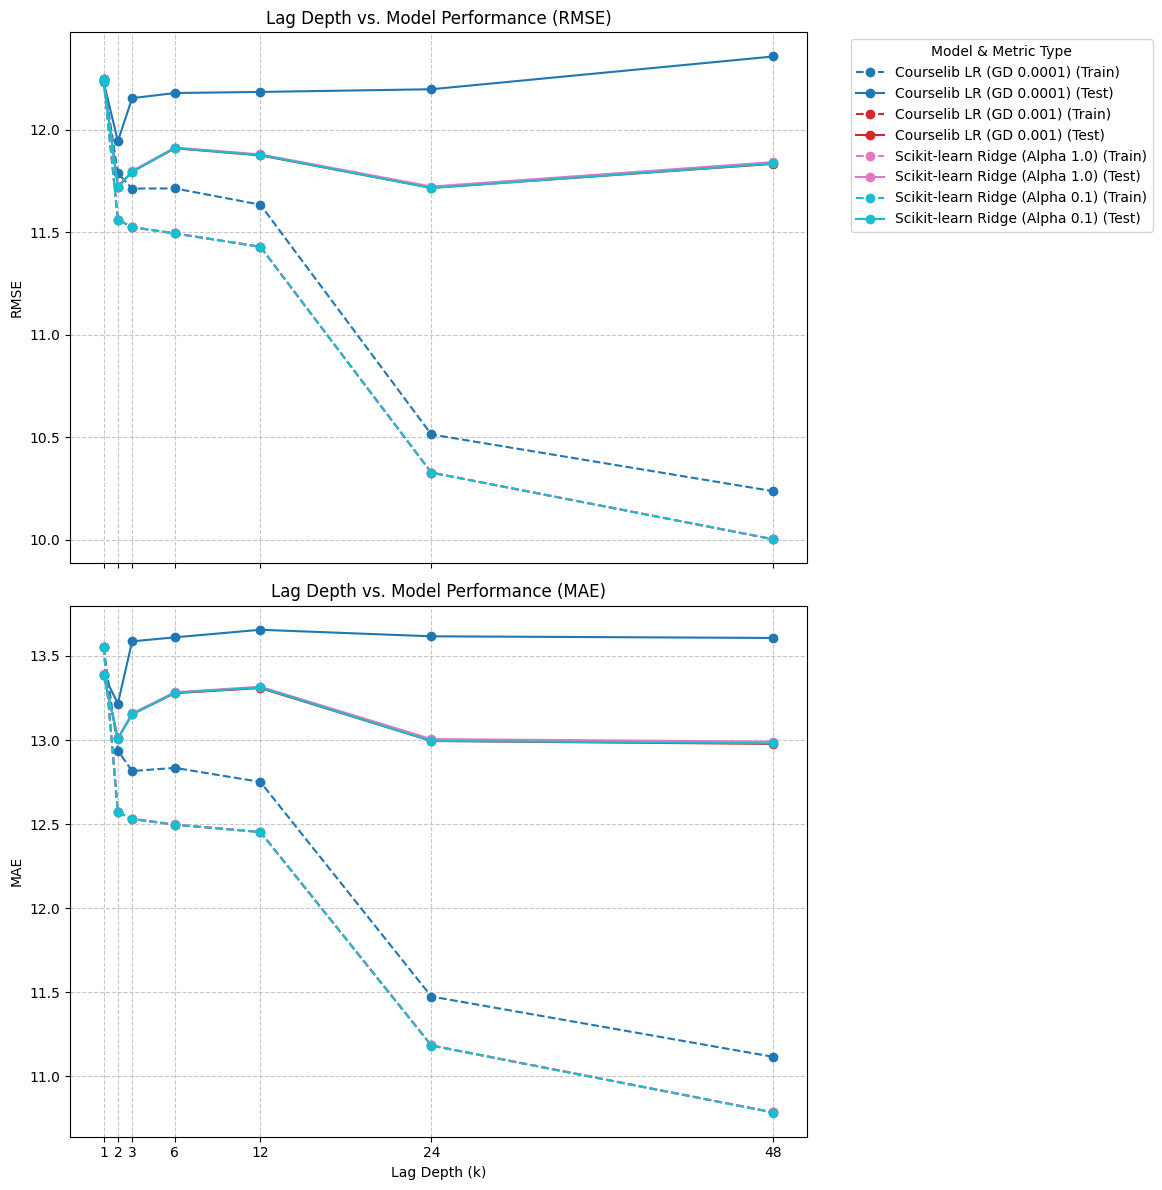

2025-07-15 21:37:20,128 - INFO - Lag depth analysis plots generated.


In [5]:
# --- Comprehensive Lag Depth Analysis and Model Selection ---

logger.info("--- Starting Comprehensive Lag Depth Analysis ---")

try:
    lag_evaluation_results_df = evaluate_lag_depth_effect(
        lag_depths_to_test=PIPELINE_TEST_LAGS,
        model_configs=PIPELINE_MODEL_CONFIGS,
        training_fraction=0.8, # Consistent with ModelEvaluator default
        target_pollutant=PIPELINE_TARGET_POLLUTANT,
        start_date=PIPELINE_START_DATE,
        end_date=PIPELINE_END_DATE
    )

    if lag_evaluation_results_df.empty:
        logger.warning("No lag depth evaluation results obtained. Skipping related plots.")
    else:
        logger.info("\n--- Lag Depth Evaluation Results Summary ---")
        display(lag_evaluation_results_df) # Display as a nice table

        # Plot Lag Depth Results
        plot_lag_depth_results(lag_evaluation_results_df)

except Exception as e:
    logger.exception("An error occurred during comprehensive lag depth analysis.")

Clearly, overfitting occurs after 24 lags - the train error falls rapidly, while the test error stays constant or rises slightly

2025-07-15 21:58:27,979 - INFO - --- Identifying Best Model and Generating Final Visualizations ---
2025-07-15 21:58:27,985 - INFO - 
--- Best Model Identified ---
2025-07-15 21:58:27,987 - INFO - Model: Scikit-learn Ridge (Alpha 0.1), Lag Depth: 24, Test RMSE: 11.7155, Test MAE: 12.9949
2025-07-15 21:58:27,988 - INFO - Re-evaluating best model 'Scikit-learn Ridge (Alpha 0.1)' with lag 24 to get predictions for detailed plots...
2025-07-15 21:58:28,148 - INFO - Raw data loaded and initially parsed.
2025-07-15 21:58:28,196 - INFO - Performing data split and scaling...
2025-07-15 21:58:28,201 - INFO - Training data shape: X=(1354, 24), y=(1354,)
2025-07-15 21:58:28,202 - INFO - Testing data shape: X=(338, 24), y=(338,)
2025-07-15 21:58:28,203 - INFO - Test Y index shape: 338
2025-07-15 21:58:28,204 - INFO - --- Starting evaluation for Scikit-learn Ridge (Alpha 0.1) ---
2025-07-15 21:58:28,211 - INFO - Model Ridge trained successfully.
2025-07-15 21:58:28,214 - INFO - Predictions generate

Generating 24 lag features and aligning target vector...


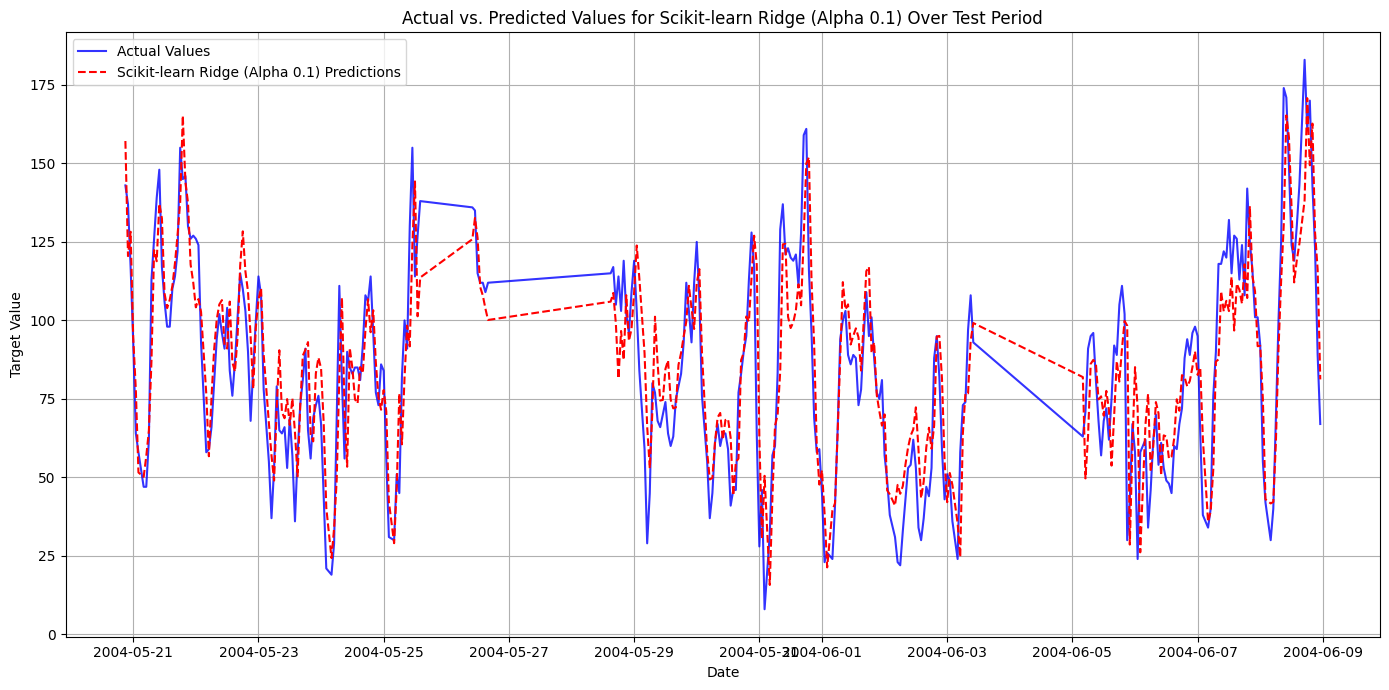

2025-07-15 21:58:28,770 - INFO - Plot: Actual vs. Predicted values for Scikit-learn Ridge (Alpha 0.1) generated.


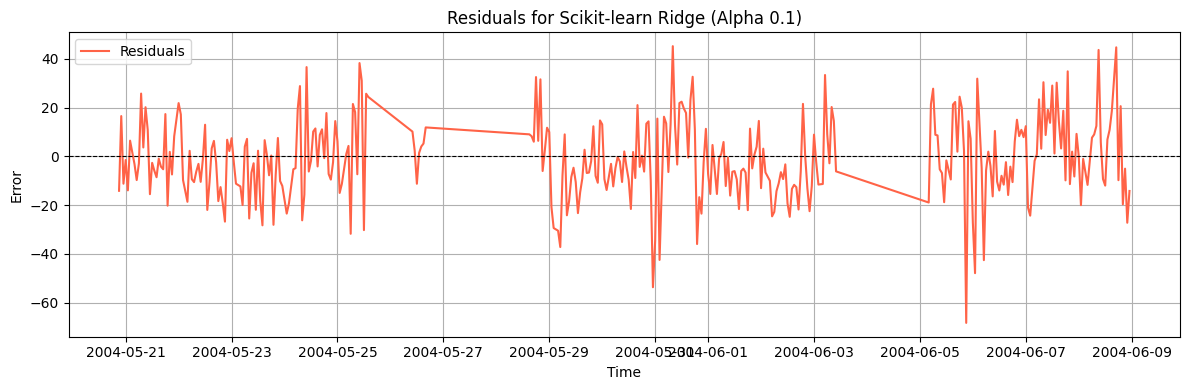

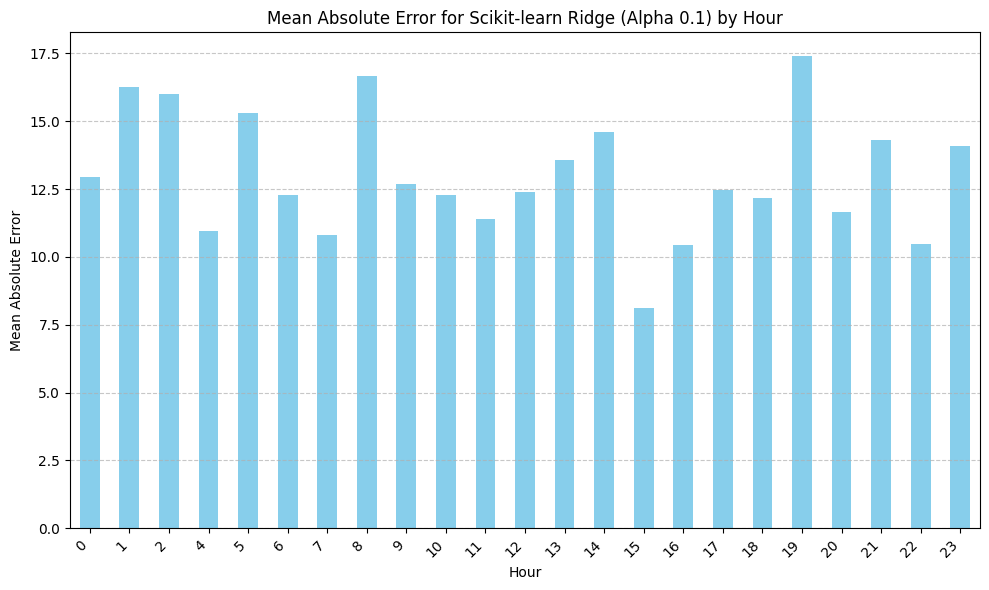

2025-07-15 21:58:30,029 - INFO - Plot: Mean Absolute Error by hour for Scikit-learn Ridge (Alpha 0.1) generated.
d:\Studium\Excercises\Applied ML\appliedML-air-quality\src\visualization\plotting.py:210: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_errors = errors_df.groupby('time_group')['error'].mean()


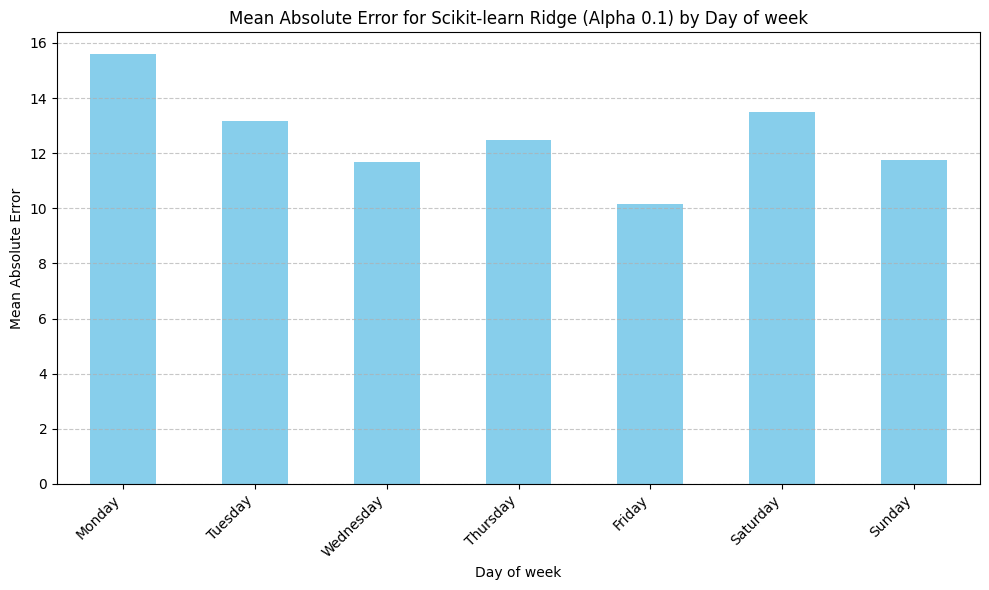

2025-07-15 21:58:30,509 - INFO - Plot: Mean Absolute Error by dayofweek for Scikit-learn Ridge (Alpha 0.1) generated.


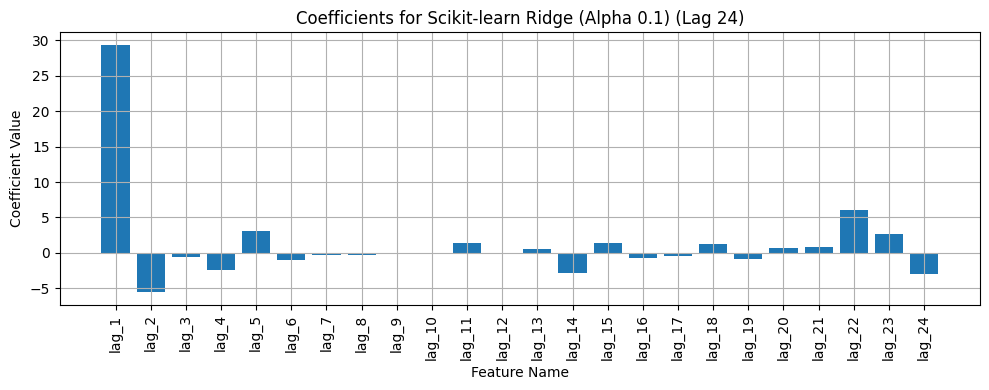

In [8]:
# Cell 5: Identify Best Model and Perform Final Visualizations

logger.info("--- Identifying Best Model and Generating Final Visualizations ---")

try:
    if 'lag_evaluation_results_df' not in locals() or lag_evaluation_results_df.empty:
        logger.warning("Lag evaluation results not available or empty. Cannot select best model.")
    else:
        # Filter for Test results and find the row with the minimum RMSE
        test_results = lag_evaluation_results_df[lag_evaluation_results_df['Metric Type'] == 'Test']
        
        if test_results.empty or 'RMSE' not in test_results.columns:
            logger.error("No valid test results found for best model selection.")
        else:
            best_model_row = test_results.loc[test_results['RMSE'].idxmin()]
            
            best_lag_depth = int(best_model_row['Lag Depth'])
            best_model_name = best_model_row['Model']
            best_model_config = PIPELINE_MODEL_CONFIGS.get(best_model_name)

            if best_model_config is None:
                logger.error(f"Configuration for best model '{best_model_name}' not found. Cannot proceed with detailed plots.")
            else:
                logger.info(f"\n--- Best Model Identified ---")
                logger.info(f"Model: {best_model_name}, Lag Depth: {best_lag_depth}, "
                            f"Test RMSE: {best_model_row['RMSE']:.4f}, Test MAE: {best_model_row['MAE']:.4f}")

                # --- Re-evaluate the best model to get its specific y_true and y_pred ---
                # This is crucial because evaluate_lag_depth_effect doesn't return the ModelEvaluator instances
                logger.info(f"Re-evaluating best model '{best_model_name}' with lag {best_lag_depth} "
                            f"to get predictions for detailed plots...")
                
                # 1. Re-get the time series (ensure consistency)
                processor_best = AirQualityProcessor(
                    target_pollutant=PIPELINE_TARGET_POLLUTANT,
                    start_date=PIPELINE_START_DATE,
                    end_date=PIPELINE_END_DATE
                )
                time_series_best = processor_best.get_target_time_series()

                # 2. Prepare lagged data for the best lag depth
                feature_engineer_best = LagFeatureEngineer(lag_depth=best_lag_depth)
                df_lagged_best = feature_engineer_best.prepare_supervised_data(time_series_best, return_separate=False)
                
                if df_lagged_best.empty:
                    logger.error(f"Lagged data for best lag depth {best_lag_depth} is empty. Cannot generate detailed plots.")
                else:
                    # 3. Instantiate a NEW ModelEvaluator for this best model/lag combination
                    evaluator_best = ModelEvaluator(df_lagged_best, training_data_fraction=0.8)
                    
                    # 4. Evaluate *only* the best model using this new evaluator instance
                    evaluator_best.evaluate_model(best_model_name, best_model_config)
                    
                    # 5. Retrieve y_true and y_pred using the existing methods from YOUR ModelEvaluator
                    y_test_best = evaluator_best.get_test_Y_series()
                    y_pred_best = evaluator_best.get_predictions_series_for_model(best_model_name)

                    if y_test_best.empty or y_pred_best.empty:
                        logger.warning("No test predictions obtained for best model. Skipping detailed plots.")
                    else:
                        # --- Final Plotting for the Best Model ---
                        logger.info("Generating detailed plots for the best model...")

                        # 1. Actual vs. Predicted Plot
                        plot_predictions_vs_actual(y_test_best, y_pred_best, model_name=best_model_name)
                        
                        # 2. Residuals Plot
                        plot_residuals(y_test_best, y_pred_best, title=f"Residuals for {best_model_name}")
                        
                        # 3. MAE by Hour of Day
                        plot_error_by_time_group(y_test_best, y_pred_best, group_by='hour', model_name=best_model_name)
                        
                        # 4. MAE by Day of Week
                        plot_error_by_time_group(y_test_best, y_pred_best, group_by='dayofweek', model_name=best_model_name)
                        
                        # 5. Plot Coefficients (if applicable)
                        # We use get_trained_model from YOUR ModelEvaluator
                        if best_model_config['model_class'] in [LinearRegression, Ridge]:
                            trained_model_for_coeffs = evaluator_best.get_trained_model(best_model_name)
                            if trained_model_for_coeffs:
                                coefficients = None
                                if isinstance(trained_model_for_coeffs, LinearRegression): # Courselib LinearRegression
                                    coefficients = trained_model_for_coeffs.w.flatten()
                                elif isinstance(trained_model_for_coeffs, (Ridge)): # Scikit-learn models
                                    coefficients = trained_model_for_coeffs.coef_.flatten()
                                
                                if coefficients is not None:
                                    lag_feature_names = [f"lag_{i+1}" for i in range(evaluator_best.train_X_raw.shape[1])] # Get actual feature count
                                    plot_coefficients(coefficients, feature_names=lag_feature_names, 
                                                    title=f"Coefficients for {best_model_name} (Lag {best_lag_depth})")
                                else:
                                    logger.info(f"Could not extract coefficients for {best_model_name} from the trained model object.")
                            else:
                                logger.warning(f"Trained model object for {best_model_name} not found in evaluator_best. Cannot plot coefficients.")
                        else:
                            logger.info(f"Skipping coefficient plot for {best_model_name} as it's not a direct linear model.")

except Exception as e:
    logger.exception("An error occurred during best model selection or final visualizations.")

In [9]:
# Cell 6: Pipeline Completion

logger.info("--- Main Machine Learning Pipeline Finished Successfully ---")

2025-07-15 21:58:56,074 - INFO - --- Main Machine Learning Pipeline Finished Successfully ---
